In [ ]:
import sys
import os
import numpy as np
import pandas as pd

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from utils import download_data
from mappings import value_mapping, ideology_mapping
# Now you can import the TimeSeriesDataset class
from TimeSeriesDataset import TimeSeriesDataset as TSD

In [2]:
# initialize dataset by downloading dataset or downloading the data from polity_url
dataset = TSD(categories=['sc'], template_path='../datasets/MSP_template.csv')
dataset.add_polities()

Loaded template from ../datasets/MSP_template.csv
Downloaded 839 rows


In [3]:
url = "https://seshatdata.com/api/crisisdb/power-transitions/"
pt_df = download_data(url)

Downloaded 3449 rows


In [4]:
# pt_df_2 = pd.read_csv("/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/power_transitions_20241122_144511.csv", sep = '|')

In [5]:
# pt_df_2 = pt_df_2.rename(columns = {'polity_new_ID': 'PolityName'})
# pt_df_2['is_disputed'] = False
# pt_df_2['is_uncertain'] = pt_df_2.contested.apply(lambda x: True if x == 'U' else False)

# pt_df_2['polity_id'] = pt_df_2.apply(lambda x: int(pt_df.loc[pt_df['polity_new_name'] == x['PolityName'], 'id'].values[0]) if x['PolityName'] in pt_df['name'].values else None, axis=1)
# pt_df = pt_df_2

In [6]:
PT_types = ['overturn', 'predecessor_assassination', 'intra_elite',
       'military_revolt', 'popular_uprising', 'separatist_rebellion',
       'external_invasion', 'external_interference']
for type in PT_types:
    pt_df[type] = pt_df[type].apply(lambda x: value_mapping[x] if x in value_mapping.keys() else np.nan)

# set nan values to 0
# pt_df.fillna(0, inplace=True)
pt_df['Crisis'] = pt_df[PT_types].sum(axis=1)


In [7]:
# add crisis to dataset
dataset.raw['Crisis'] = np.nan

for idx, row in pt_df.iterrows():
    polity = row['polity_id']
    if polity not in dataset.raw.PolityID.unique():
        continue
    year_from = row['year_from']
    year_to = row['year_to']
    if pd.notna(year_from) and pd.notna(year_to):
        year = np.mean([year_from,year_to])
    elif pd.notna(year_from) and pd.isna(year_to):
        year = year_to
    elif pd.isna(year_from) and pd.notna(year_to):
        year = year_from
    elif pd.isna(year_from) and pd.isna(year_to):
        year = np.nan
    dataset.add_years(polID=polity, year=year)
    dataset.raw.loc[dataset.raw.Year == year,'Crisis'] = row.Crisis

In [8]:
dataset.raw = dataset.raw.loc[(dataset.raw.Year.notna())&(dataset.raw.Year!=0)]

# delete duplicates
dataset.raw.drop_duplicates(subset=['PolityID', 'Year'], inplace=True)

dataset.raw = dataset.raw.sort_values(by=['PolityID', 'Year'])
dataset.raw.reset_index(drop=True, inplace=True)

In [9]:
dataset.download_all_categories()

Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end ye

In [10]:
from mappings import ideology_mapping

for key in ideology_mapping['MSP'].keys():
    dataset.add_column('ideo/'+key.lower())

Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end year
Error: The year is outside the polity's start and end ye

In [11]:
# remove all rows that have less than 30% of the columns filled in
dataset.remove_incomplete_rows(nan_threshold=0.3)
# build the social complexity variables
dataset.build_social_complexity()
dataset.build_MSP()

dataset.scv['Crisis'] = dataset.raw.Crisis

In [12]:
# impute missing data
imp_columns =  ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money']
dataset.impute_missing_values(columns=imp_columns)

In [13]:
dataset.scv_imputed['Crisis'] = dataset.scv['Crisis']

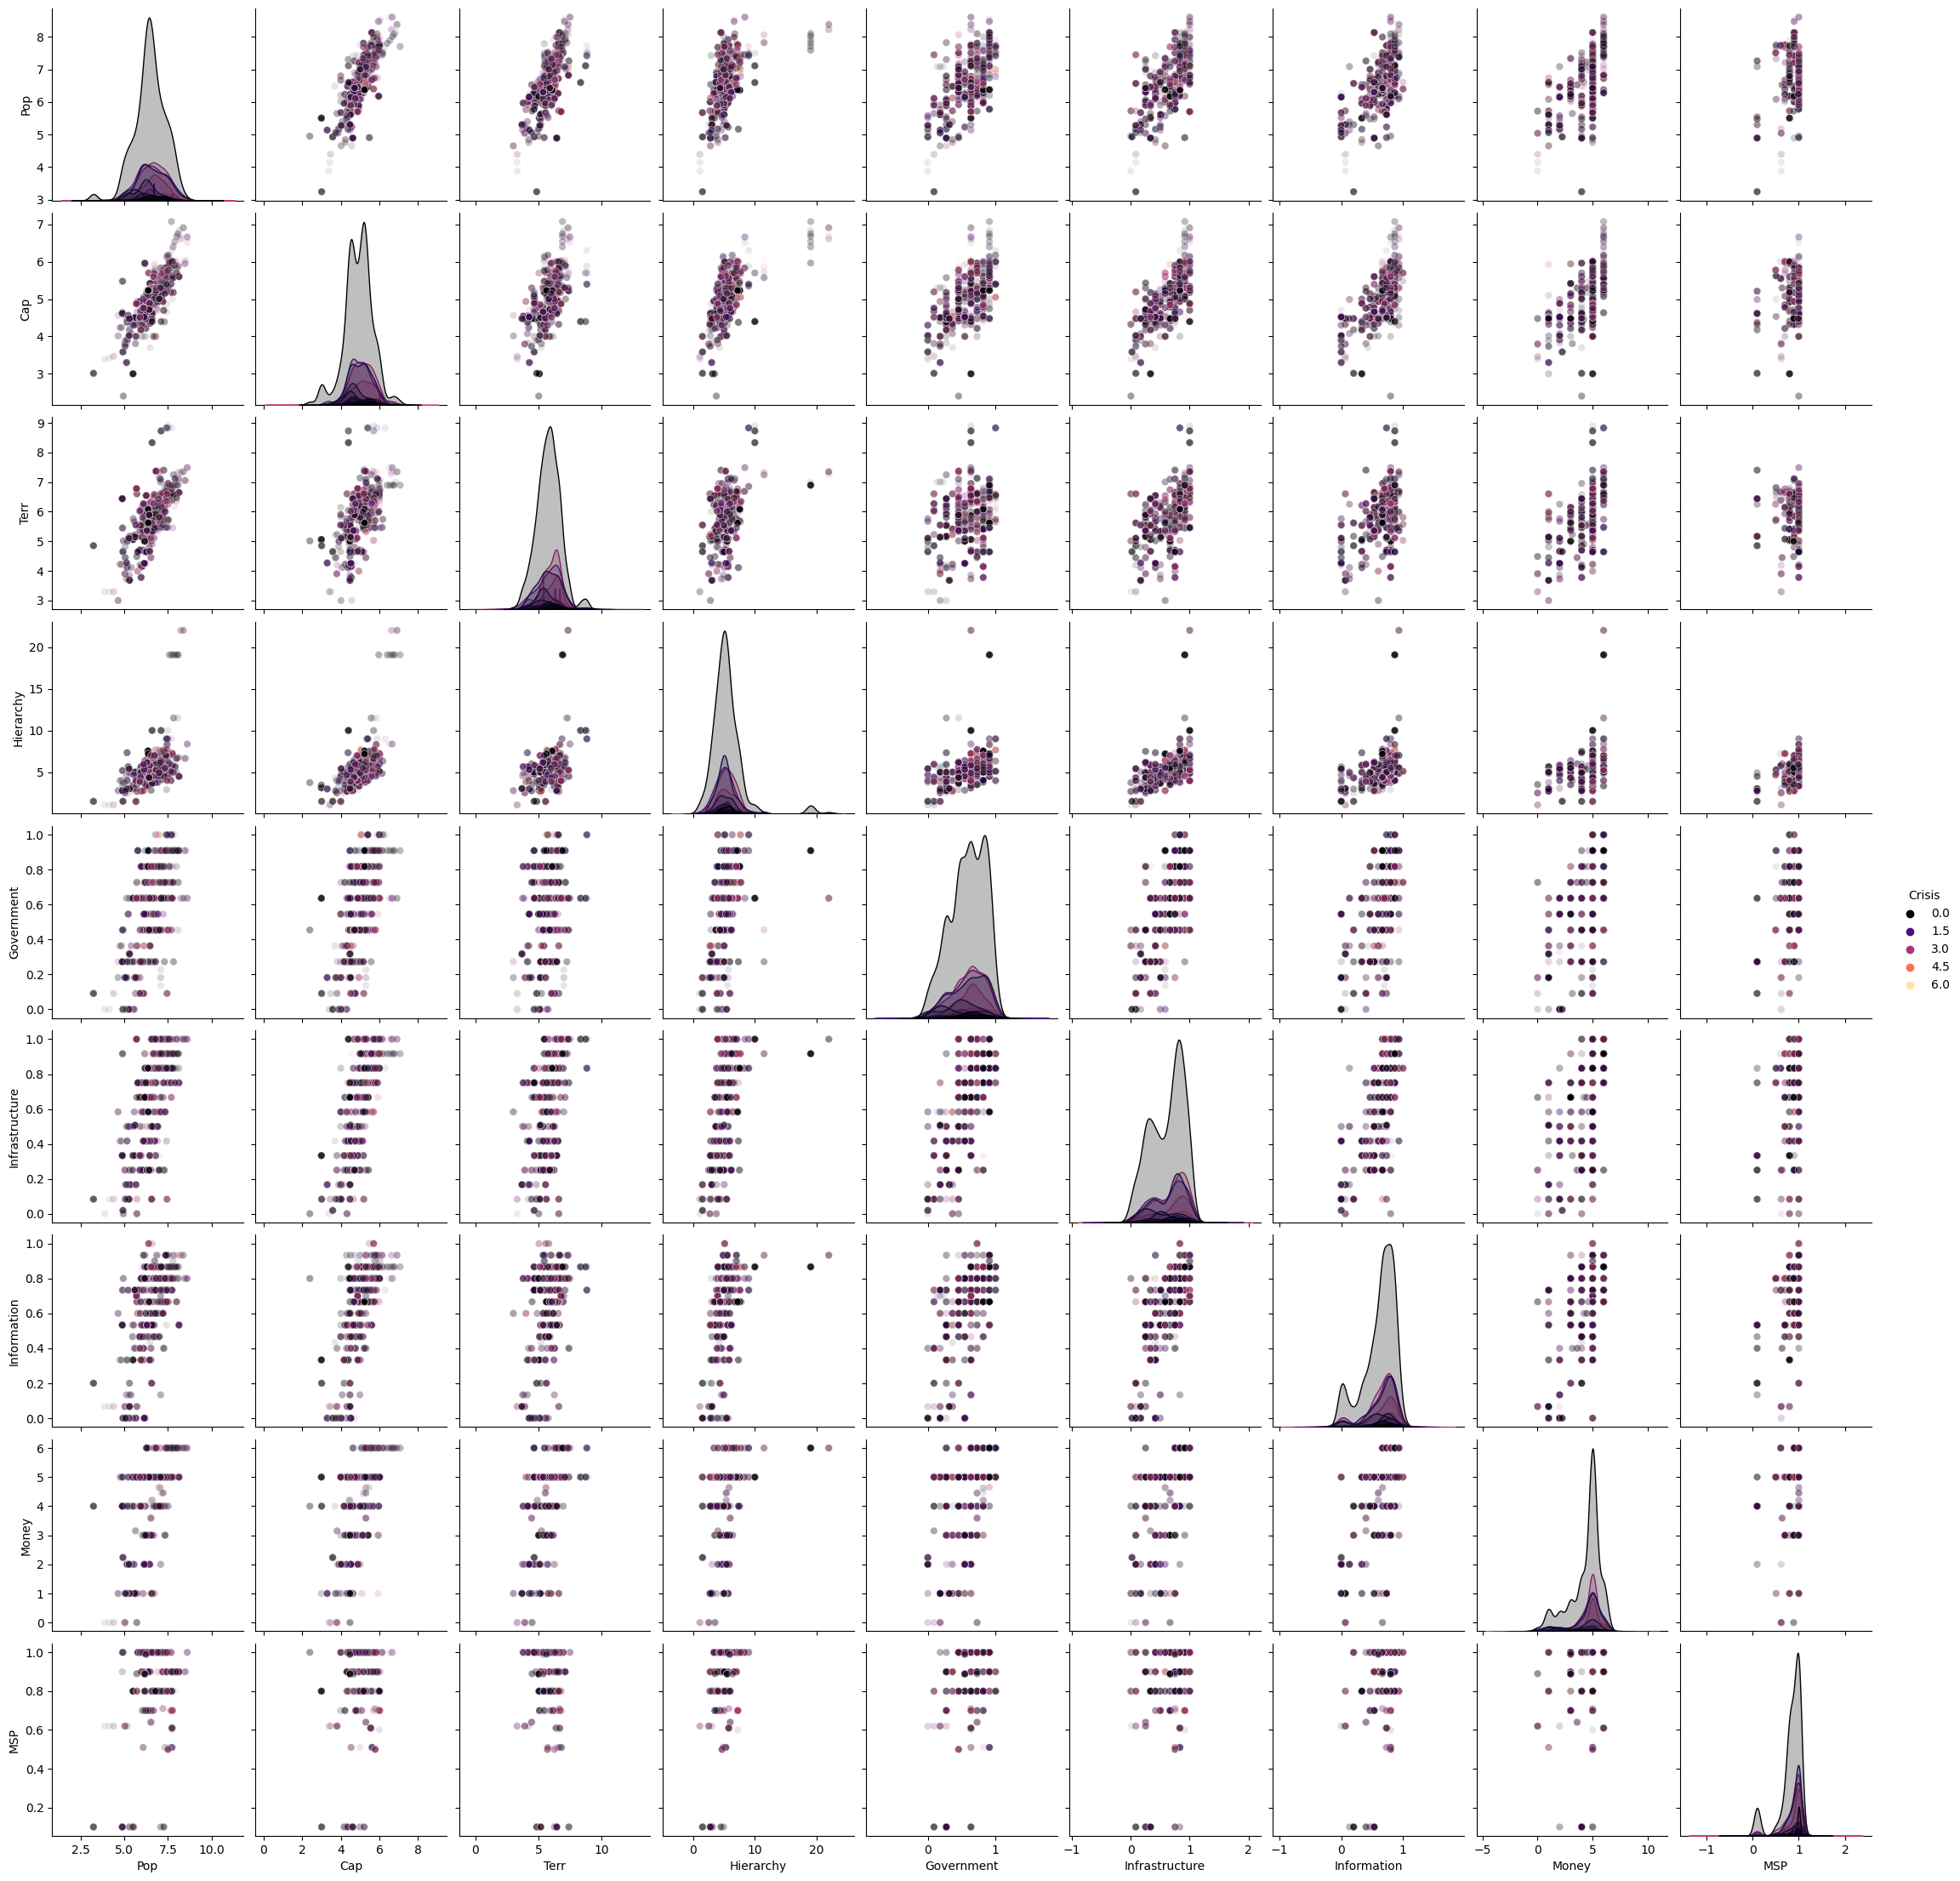

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sc_columns = ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money', 'Crisis', 'MSP']

sns.pairplot(dataset.scv_imputed[sc_columns], hue='Crisis', palette = 'magma' , plot_kws={'alpha': 0.1})
plt.show()

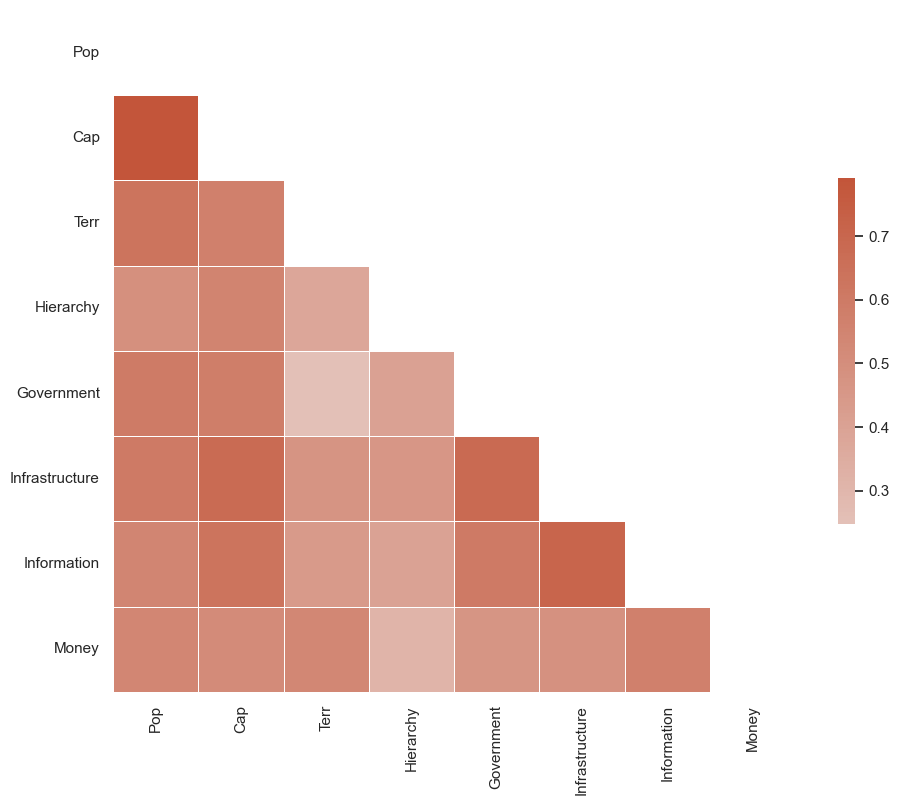

In [15]:
sc_columns = ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money']


sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = dataset.scv_imputed[sc_columns]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [17]:
dataset.save_dataset(path='../datasets/', name='power_transitions')

Dataset saved to ../datasets/power_transitions.xlsx
